if intersection of refs of derworks > median put in above
<br>
use only above median dworks for getting the refs of ddworks

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [ ]:
def clean(name):
  to_remove = ['-',',',':',';','.','?','(',')','/']
  name = name.lower()
  name = name.strip()

  for char in to_remove:
    name = name.replace(char,'')
  name = name.replace('&','and')

  return(name)

def check_intersection2(t1,t2,thresh=0.8):
  t1 = set(t1.split(' '))
  t2 = set(t2.split(' '))

  intersect = len(t1.intersection(t2))
  if(intersect/len(t2))>=thresh and (intersect/len(t1))>=thresh:
    return(1)
  return(0)

def check_nameInList(name,nameList):
  for n in nameList:
    if(len(name) in range(len(n)-2,len(n)+3) and check_intersection2(name,n)):
      return(n)
  return(0)

In [ ]:
def make_list(string):
  # print(string)
  if(isinstance(string,str)):
    string = string.split(' #;# ')
  else:
    string = []
  # string = [int(x) for x in string]
  return(string)

def base_refs(base_path):
  df_base = pd.read_csv(base_path)

  d = dict()
  for index,rows in df_base.iterrows():
    d[clean(rows['title s2orc'])] = make_list(rows['Ref IDs'])

  return(d)

def der_base_dict(base_path, der_path):
  df_base = pd.read_csv(base_path)
  df_der = pd.read_csv(der_path) 
  
  base = list(df_base['title s2orc'])
  base = [clean(x) for x in base]
  base = set(base)

  d = dict()
  for index,rows in df_der.iterrows():
    # der = rows['ID']
    der = rows['ddId']

    par = clean(rows['Parent'])

    n = check_nameInList(par,base)
    if (n!=0):
      if (n in d.keys()):
        d[n].append(der)
      else:
        d[n] = [der]

  base_wo_ders = base - set(d.keys())
  # print(base_wo_ders)
  for b in base_wo_ders:
    d[b] = []


  return(d)


def der_refs(der_path):
  df_ref = pd.read_csv(der_path)

  d = dict()
  for index,rows in df_ref.iterrows():
    # d[rows['ID']] = make_list(rows['Ref IDs'])
    d[rows['ddId']] = make_list(rows['Ref IDs'])

  return(d)

def score(dref,bref):
  # perc of papers cited by base that are cited by dref with respect to base
  # print('%',dref)
  dref = set(dref)
  bref = set(bref)
  # print(dref)
  # print(bref)
  intersect = bref.intersection(dref)
  # return(len(intersect))
  if(len(bref)==0):
    return(0)
  return(len(intersect)/len(bref))

def get_base_edgewts(base_path,der_path):
  der_dict = der_refs(der_path)
  base_dict = base_refs(base_path)
  der_base = der_base_dict(base_path,der_path)

  wts = {}

  for paper in list(base_dict.keys()):
    ders = der_base[paper]
    baserefs = base_dict[paper]

    scores = []
    for d in ders:
      # if(d in der_dict.keys()):
      derrefs = der_dict[d]
      s = score(derrefs,baserefs)
      scores.append(s)

    scores = [str(x) for x in scores]
    # wts.append(' #;# '.join(scores))
    wts[paper] = ' #;# '.join(scores)

  return(wts)

def filter_der(base_path,der_path,thresh=0.5):
  der_dict = der_refs(der_path)
  base_dict = base_refs(base_path)
  der_base = der_base_dict(base_path,der_path)

  i=0
  scores = []

  new_ders = dict()

  for paper in list(base_dict.keys()):
    i+=1
    ders = der_base[paper]
    baserefs = base_dict[paper]
    ders_filtered = []
    for d in ders:
      # if(d in der_dict.keys()):
      derrefs = der_dict[d]
      s = score(derrefs,baserefs)
      if(not np.isnan(s)):
        scores.append(s)
        if (s>=thresh):
          ders_filtered.append(d)
    new_ders[paper] = ders_filtered

  return(new_ders,scores)


def filter_der_below(base_path,der_path,thresh=0.5):
  der_dict = der_refs(der_path)
  base_dict = base_refs(base_path)
  der_base = der_base_dict(base_path,der_path)

  i=0
  scores = []

  new_ders = dict()

  for paper in list(base_dict.keys()):
    i+=1
    ders = der_base[paper]
    baserefs = base_dict[paper]
    ders_filtered = []
    for d in ders:
      # if(d in der_dict.keys()):
      derrefs = der_dict[d]
      s = score(derrefs,baserefs)
      if(not np.isnan(s)):
        scores.append(s)
        if (s<thresh):
          ders_filtered.append(d)
    new_ders[paper] = ders_filtered

  return(new_ders,scores)


In [ ]:
def get_scoredist(pool,thresh=0.2):
  base = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/baseRefs_Pool'+pool.upper()+'.csv'
  der = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_Pool'+pool.upper()+'.csv'
  new_ders,scores = filter_der(base,der,thresh)
  lens = [len(value) for key,value in new_ders.items()]
  lens = scores
  mean = sum(lens)/len(lens)
  print('Mean: ',mean)
  variance = [(x-mean)**2 for x in lens]
  std_dev = (sum(variance)/len(lens))**0.5
  print('Std Dev: ',std_dev)
  median = statistics.median(scores)
  print('Median: ',median)
  print('\nHistogram')
  plt.hist(np.array(lens), bins=10, histtype ='bar')
  plt.show()

Mean:  0.19750451293092644
Std Dev:  0.16613115282181035
Median:  0.16129032258064516

Histogram


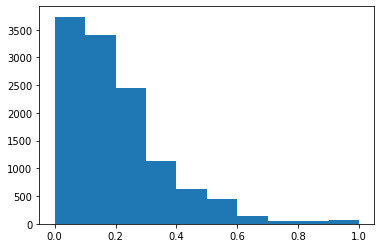

In [ ]:
get_scoredist('A')

Mean:  0.17301451159085826
Std Dev:  0.1606234772126844
Median:  0.13333333333333333

Histogram


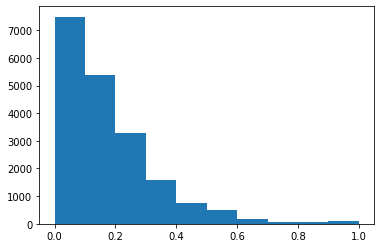

In [ ]:
get_scoredist('B')

Mean:  0.19233862852039232
Std Dev:  0.17126462443524285
Median:  0.15

Histogram


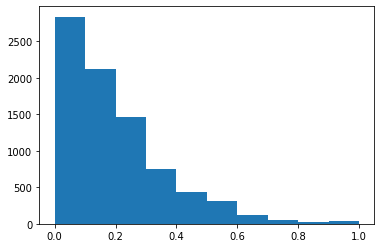

In [ ]:
get_scoredist('C')

In [ ]:
def filter_dercount(pool,thresh=0.2):
  fil_der_names = []
  base = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/baseRefs_Pool'+pool.upper()+'.csv'
  der = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_Pool'+pool.upper()+'.csv'
  new_ders,scores = filter_der_below(base,der,thresh)
  lens = [len(value) for key,value in new_ders.items()]
  for key,values in new_ders.items():
    fil_der_names.extend(values)
  mean = sum(lens)/len(lens)
  print('Mean: ',mean)
  variance = [(x-mean)**2 for x in lens]
  std_dev = (sum(variance)/len(lens))**0.5
  print('Std Dev: ',std_dev)
  median = statistics.median(lens)
  print('Median: ',median)
  print('\nHistogram')
  plt.hist(np.array(lens), bins=10, histtype ='bar')
  plt.show()
  return(fil_der_names)

Mean:  3.4134615384615383
Std Dev:  3.1800032385104404
Median:  3.0

Histogram


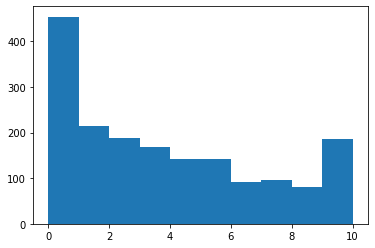

In [ ]:
fil_A = filter_dercount('A',0.16129032258064516)

In [ ]:
len(fil_A)

6035

In [ ]:
with open('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative works of derivative works (Task 1.5)/belowMed_derworks_A.txt','w+') as f:
  for paper in fil_A:
    f.write(paper+'\n')

Mean:  3.566852886405959
Std Dev:  3.2642325465601134
Median:  3

Histogram


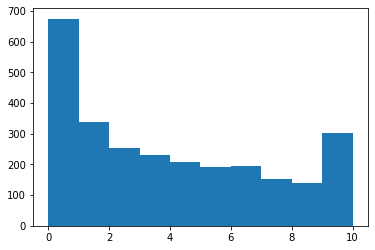

In [ ]:
fil_B = filter_dercount('B',0.13333333333333333)

In [ ]:
len(fil_B)

9577

In [ ]:
with open('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative works of derivative works (Task 1.5)/belowMed_derworks_B.txt','w+') as f:
  for paper in fil_B:
    f.write(paper+'\n')

Mean:  4.029850746268656
Std Dev:  3.448138076792867
Median:  3

Histogram


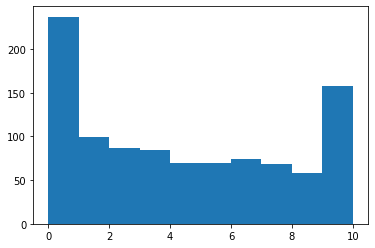

In [ ]:
fil_C = filter_dercount('C',0.15)

In [ ]:
len(fil_C)

4050

In [ ]:
with open('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative works of derivative works (Task 1.5)/belowMed_derworks_C.txt','w+') as f:
  for paper in fil_C:
    f.write(paper+'\n')

### Results:
<p> On average, about 2-3 derivative works of a paper cite more than 20% of the references of the base paper</p>
<p> On average, 0 derivative works of a paper cite more than 50% of the references of the base paper</p>
<hr>
<p> On combining the references of all the derivative works of papers, there is 50% intersection. However individually, the derivative works papers cite about 15-17% of the references of the paper</p>
<br>
<hr>
<p> Total 20060 deriavtive works to get derivative works of using download bib code</p>

In [ ]:
def filter_der(base_path,der_path):
  der_dict = der_refs(der_path)
  base_dict = base_refs(base_path)
  der_base = der_base_dict(base_path,der_path)

  i=0
  scores = dict()

  # new_ders = dict()

  for paper in list(base_dict.keys()):
    scores[paper] = []
    i+=1
    ders = der_base[paper]
    baserefs = base_dict[paper]
    # ders_filtered = []
    for d in ders:
      # if(d in der_dict.keys()):
      derrefs = der_dict[d]
      s = score(derrefs,baserefs)
      scores[paper].append(s)
      # if(not np.isnan(s)):
      #   scores.append(s)
      #   if (s>=thresh):
      #     ders_filtered.append(d)
    # new_ders[paper] = ders_filtered

  return(scores)

In [ ]:
pool = 'C'
base = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/baseRefs_Pool'+pool.upper()+'.csv'
der = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_Pool'+pool.upper()+'.csv'
scores = filter_der(base,der)

In [ ]:
names = scores.keys()
ref = scores.values()

df = pd.DataFrame({'names':names,'ref':ref})
len(df)

1005

In [ ]:
df.to_csv('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/ref_int(b_d)_pool'+pool.upper()+'.csv',index=False)

## Get edge weights

In [ ]:
def get_edgewts(pool):
  base = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/baseRefs_Pool'+pool.upper()+'.csv'
  der = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_Pool'+pool.upper()+'.csv'

  wts = get_base_edgewts(base,der)
  
  df = pd.DataFrame({'name':wts.keys(),'scores':wts.values()})
  # df['wts'] = wts
  df.to_csv('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/pool'+pool.upper()+'_base_edgewts.csv',index=False)

In [ ]:
get_edgewts('A')

In [ ]:
get_edgewts('B')

In [ ]:
get_edgewts('C')

In [ ]:
def get_edgewts(pool):
  der_ab = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative_works_of_derivative_works_Task1.5/ddWorks_refs/'+pool.upper()+'/above/ddRefs_Pool'+pool.upper()+'_above.csv'
  der_be = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative_works_of_derivative_works_Task1.5/ddWorks_refs/'+pool.upper()+'/below/ddRefs_Pool'+pool.upper()+'_below.csv'
  
  der_ab = pd.read_csv(der_ab)
  der_be = pd.read_csv(der_be)

  der = pd.concat([der_ab,der_be],ignore_index=True)
  der.to_csv('temp.csv',index=False)

  print(der.head())
  
  der = 'temp.csv'
  base = '/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_Pool'+pool.upper()+'.csv'

  wts = get_base_edgewts(base,der)
  
  df = pd.DataFrame({'name':wts.keys(),'scores':wts.values()})
  # df['wts'] = wts
  df.to_csv('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/pool'+pool.upper()+'_der_edgewts.csv',index=False)

In [ ]:
get_edgewts('A')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative_works_of_derivative_works_Task1.5/ddWorks_refs/A/above/ddRefs_PoolA_above.csv')
df.head()

,ddName,ddId,Ref IDs,Ref Names
0,An Update on Statistical Boosting in Biomedicine,b14623ee36097b99b04a2865dcf988085f38fea8,79c7d6903e12e1b45bb3f8bc6ca862fed92b06ea #;# c...,Estimating High-Dimensional Directed Acyclic G...
1,Significance Tests for Boosted Location and Sc...,1ae94b179b099fdba5b306d3941831c23cdaf108,906569bb9f527aa1f73f38526ada9abe666f2cf8 #;# 7...,Pairwise likelihood ratios for estimation of n...
2,Boosting for statistical modelling-A non-techn...,f426918080b3a91207b6c4b1a641a5198aa0c8b8,0d86fbca1fbdb7c8e5a10c2d2c5a0ff3e07eea15 #;# a...,A Kernel Statistical Test of Independence #;# ...
3,Boosting joint models for longitudinal and tim...,e774e704898d6292a03ee38e022872c52c6bf272,478e3b41718d8abcd7492a0dd4d18ae63e6709ab #;# 7...,A Linear Non-Gaussian Acyclic Model for Causal...
4,Boosting functional regression models,9d2aa689305a0fb4230af70c7e05fdcb030aa182,9773ad3ab86b7f8205ff0774bef6fabeeb417075 #;# f...,Computing the Multinomial Stochastic Complexit...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SAHA PROJECT - connectedpapers zip files/Derivative Works (Task 1)/References/derRefs_PoolC.csv')
df.head()

,ID,Name,Parent,Ref IDs,Ref Names
0,3267276d0bff217e9a3d6b1b107d063c2e2f39dc,Role of CaMKII and the GluN2B subunit of the N...,Dopaminedependent plasticity of corticostriata...,f1c159ae0ff82ad097d179c14612c2bd17647e65 #;# 4...,Inhibition of voltage-gated Ca2+ channels and ...
1,8247e7fad552649d1e7165366a13f12bdb9f643b,Transmission et plasticité activité-dépendant...,Dopaminedependent plasticity of corticostriata...,46638846cac171bfa7a787f6cfe27a6385ac0c95 #;# f...,Cortical Slow Oscillatory Activity Is Reflecte...
2,2a9f29979701340a64bad9ccb60fd33108333e29,Synaptic plasticity in the basal ganglia,Dopaminedependent plasticity of corticostriata...,cb0c11f3015507af6cad34aaa4905f8eacf7027e #;# 2...,Neuronal activity in monkey ventral striatum r...
3,47bedbee48d649fa2a978340805b25bdee32855a,Synaptic plasticity in the basal ganglia: A s...,Dopaminedependent plasticity of corticostriata...,2f373b9574ff6a90e5b3cec3c78dc29e283395c5 #;# 6...,An experimental test of the role of postsynapt...
4,a3e1cb8e3a30e1f39e7a06bd3442d8771549ee1c,"Synaptic Triad in the Neostriatum: Dopamine, ...",Dopaminedependent plasticity of corticostriata...,2d1914856b6cfb4065b2aa27240b36a0c0f44ae4 #;# c...,Postsynaptic endocannabinoid release is critic...
